In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns;

%matplotlib inline

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

# Load experiment Design Data

## 1. Load Email list

In [2]:
# hard code Email lists. Email ID is the index of the Email in the list

PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment', 
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']
len(PO_number_list)

10

## 2. Load user segment information

In [3]:
segment_group_init_df = pd.read_csv('/Users/qingyifang/Desktop/project/proj3/sample_segment_groups.csv')
segment_group_init_df = segment_group_init_df.drop(columns='Unnamed: 0')
segment_group_init_df.head(20)

,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,False,False,True,False,314921,20D_Act
2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,False,True,False,False,941341,link
4,4,False,True,True,False,102541,link-20D_Act
5,5,False,True,True,True,136513,link-20D_Act-5D_Act
6,6,True,False,False,False,814827,6M_App
7,7,True,False,True,False,218938,6M_App-20D_Act
8,8,True,False,True,True,233445,6M_App-20D_Act-5D_Act
9,9,True,True,False,False,127008,6M_App-link


## 3. Load sampled users with Email delivery orders for the experiment

In [4]:
sample_exp_df = pd.read_csv('/Users/qingyifang/Desktop/直通硅谷/project/proj3/sample_uuid_email_order.csv')
sample_exp_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [5]:
sample_exp_df.shape

(480000, 13)

## 4. load Email Events

In [6]:
email_event_summary_df = pd.read_csv('/Users/qingyifang/Desktop/project/proj3/email_events.csv')

In [7]:
email_event_summary_df.head()

,stitch_email_events.category,stitch_email_events.dt_date,user_uuid,event,reason,stitch_email_events.count_events
0,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_13999943483500367320,open,NaN,1
1,"[""ml_explore_the_app_investing"",""post-office""]",2020-12-30,id_3965698071238241409,open,NaN,1
2,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_9648414115970654735,open,NaN,1
3,"[""ml_investing_starts_here"",""post-office""]",2020-12-30,id_8951454012305223869,open,NaN,1
4,"[""ml_investing_101"",""post-office""]",2020-12-30,id_8180145303883056882,open,NaN,2


In [8]:
email_event_summary_df['event'].unique()

array(['open', 'unsubscribe', 'spamreport', 'deferred', 'bounce',
       'processed', 'delivered', 'dropped'], dtype=object)

## 5. load current user status

In [9]:
user_event_df = pd.read_csv('/Users/qingyifang/Desktop/project/proj3/user_events.csv')
user_event_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## 6. Load the current status for control groups.

Thay have the same sagmentation rules in the beginning of the experiment.  
These users did not received any Emails during the experiment.

In [10]:
fund_control_df = pd.read_csv('/Users/qingyifang/Desktop/project/proj3/control_groups_rate.csv')
fund_control_df.head()

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000


# Question 1: Email Open Rate
#### a.	What is the best Email to send?
Since the most important thing in our metrics is open rate, we should first conduct an open rate data frame

In [11]:
#open_rate = num_open / num_delivered
#let's first find num_delivered
delivered_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]

#remove NaN for every mail theme
for i in PO_number_list:
    delivered_count_df[i] = delivered_count_df[i].notnull()
    
#count the number of delivered under each segment group
delivered_count_df = delivered_count_df.groupby('group_name').sum().reset_index()
delivered_count_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,19230,19257,19252,19251,19253,19251,19271,19265,19241,19249
1,20D_Act-5D_Act_W,17412,17292,17346,17323,17299,17365,17319,17294,17347,17294
2,20D_Act_D,19062,19040,19054,19055,19060,19050,19056,19050,19052,19042
3,20D_Act_W,17202,17132,17148,17107,17052,17156,17108,17097,17156,17094
4,6M_App-20D_Act-5D_Act_D,19290,19285,19268,19289,19283,19285,19270,19282,19308,19273


In [12]:
#let's now find num_open
open_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]

#filter to only status of 'open'
for i in PO_number_list:
    open_count_df[i] = open_count_df[i] == 'open'

#count the number of opened under each segment group
open_count_df = open_count_df.groupby('group_name').sum().reset_index()
open_count_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,3191,3140,3171,5054,3407,3215,3306,3243,3043,3290
1,20D_Act-5D_Act_W,2873,2875,2843,4545,3117,2878,2924,2869,2829,2879
2,20D_Act_D,3464,3455,3487,5108,3650,3501,3545,3476,3524,3520
3,20D_Act_W,3022,3094,3058,4598,3146,3134,3084,3113,3010,3170
4,6M_App-20D_Act-5D_Act_D,3465,3493,3423,4896,3698,3486,3644,3520,3430,3590


In [13]:
#now use open_rate = num_open / num_delivered to find open_rate
open_rate_df = open_count_df.copy() #using deep copy to not mess up with open_count_df
for i in PO_number_list:
    open_rate_df[i] = open_count_df[i]/delivered_count_df[i]

open_rate_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918
1,20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474
2,20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855
3,20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445
4,6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271


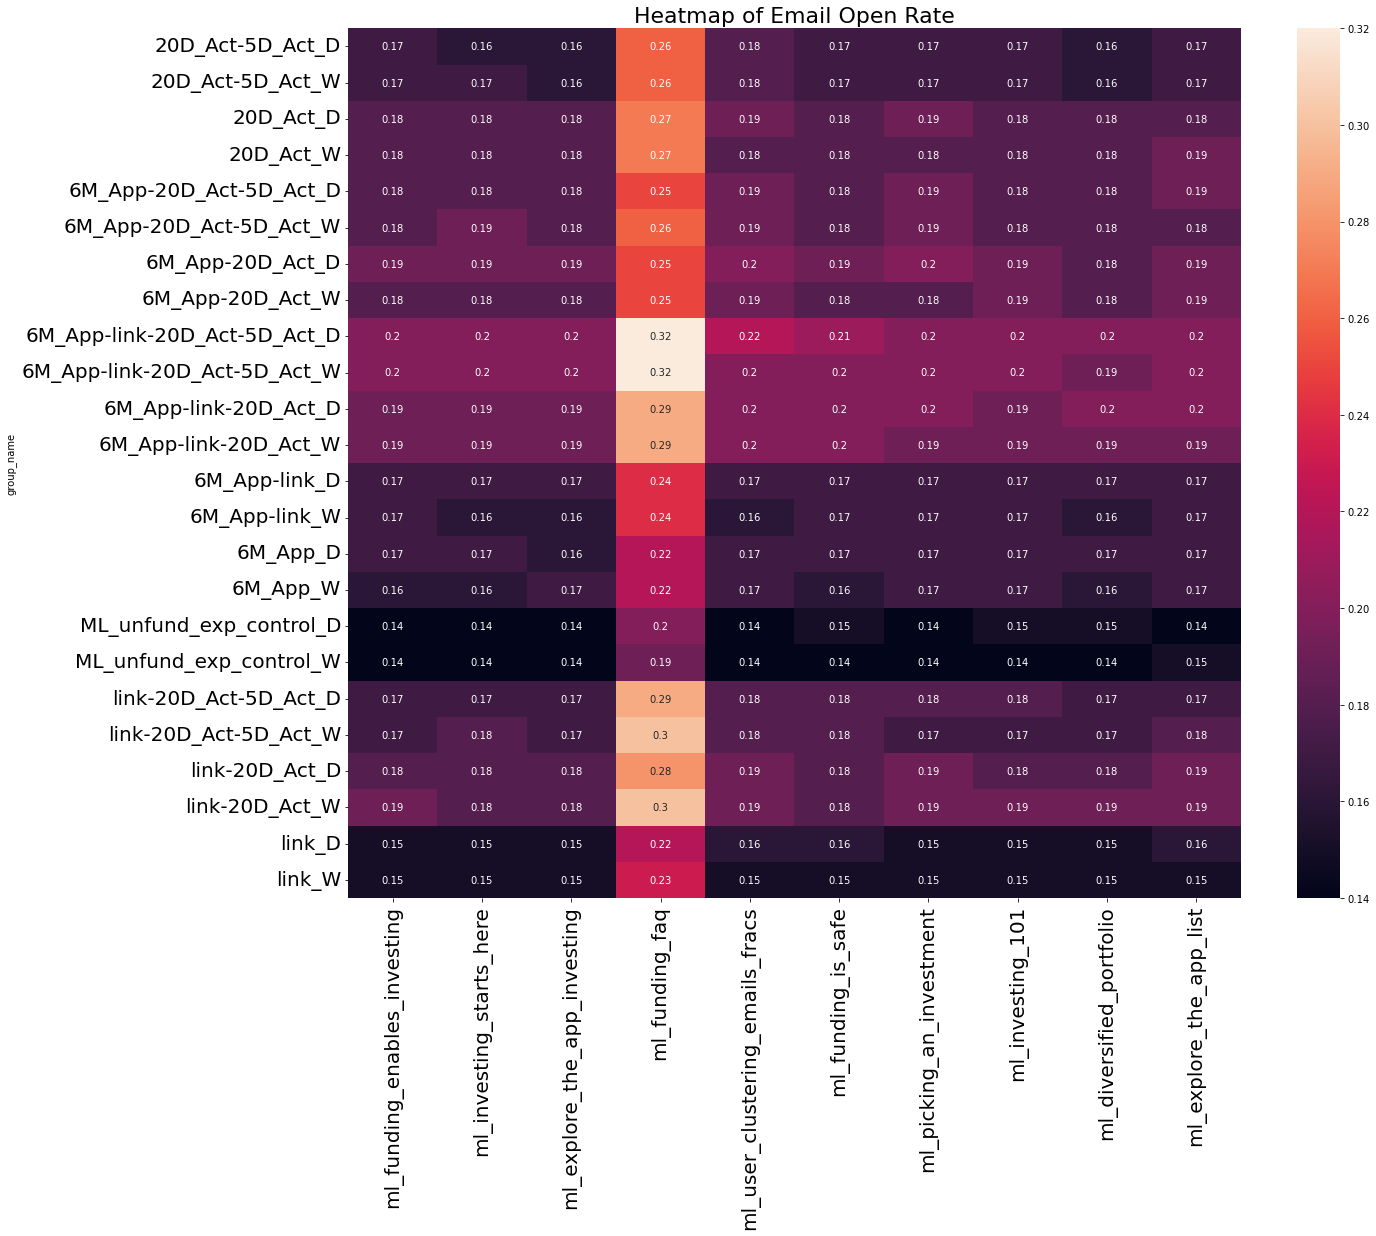

In [14]:
#visualization using heatmap, we are using heatmap because our data frame is very fit for heatmap, we have two big 
#variables: segment groups and mail lists, and each of them need to be paired together
result = open_rate_df.round(2).set_index('group_name')
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(result, annot=True, fmt="g")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email Open Rate', fontsize=22)

plt.show()

As we could see from the above heatmap, the white square represents the most effective email theme and segment group which is 'ml_funding_faq' and '6M_App-link-20D_Act-5D_Act_W/D' respectively.

#### b.	What are the important user segment factors that correlate to Email open rate?

In [15]:
#first seperate open_rate_df's segment group to daily and weekly
open_rate_dw_df = open_rate_df.copy()

#add two columns of either true or false of whether it is in daily group or twice a week group
open_rate_dw_df['daily'] = open_rate_dw_df['group_name'].str.contains('_D')
open_rate_dw_df['twice_weekly'] = open_rate_dw_df['group_name'].str.contains('_W')

#delete the _D/W so that we could merge open_rate_dw_df with segment_group_init_df
open_rate_dw_df['group_name'] = open_rate_dw_df['group_name'].str.strip('_D')
open_rate_dw_df['group_name'] = open_rate_dw_df['group_name'].str.strip('_W')

#merge two df because we need user segment factors
open_rate_dw_df = open_rate_dw_df.merge(segment_group_init_df, how = 'left', on = 'group_name')
open_rate_dw_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_weekly,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid
0,20D_Act-5D_Act,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,True,False,2,False,False,True,True,409786
1,20D_Act-5D_Act,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,False,True,2,False,False,True,True,409786
2,20D_Act,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855,True,False,1,False,False,True,False,314921
3,20D_Act,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,False,True,1,False,False,True,False,314921
4,6M_App-20D_Act-5D_Act,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,True,False,8,True,False,True,True,233445


In [16]:
#we need to have each open rate paired by group_name and mailing list
open_rate_tf_df = open_rate_dw_df.copy()
open_rate_tf_df[PO_number_list] = False #first set all mailing list to be false, change one of each to true later each time

open_rate_corr = pd.DataFrame()
for i in PO_number_list:
    temp = open_rate_tf_df.copy()
    temp[i] = True #turn to each mail theme, that theme became true
    temp['open_rate'] = open_rate_dw_df[i] #get the open rate for the specific pair
    open_rate_corr = pd.concat([open_rate_dw_df, temp])
    
open_rate_corr.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_weekly,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,open_rate
0,20D_Act-5D_Act,0.165939,0.163058,0.16471,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,True,False,2,False,False,True,True,409786,NaN
1,20D_Act-5D_Act,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,False,True,2,False,False,True,True,409786,NaN
2,20D_Act,0.181723,0.18146,0.183006,0.268066,0.191501,0.18378,0.186031,0.182467,0.184967,0.184855,True,False,1,False,False,True,False,314921,NaN
3,20D_Act,0.175677,0.180598,0.17833,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,False,True,1,False,False,True,False,314921,NaN
4,6M_App-20D_Act-5D_Act,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,True,False,8,True,False,True,True,233445,NaN


In [17]:
corr = open_rate_corr.corr()
corr['open_rate']

daily                           0.043099
twice_weekly                   -0.043099
group_id                        0.667095
approved_within6M_flag          0.495584
link_flag                       0.226826
recent_activity_flag(20days)    0.771826
5day_trade_flag                 0.237619
user_uuid                      -0.737821
open_rate                       1.000000
Name: open_rate, dtype: float64

As we can see from above, the importance of user segment factors that correlated to Email open rate order is  recent_activity_flag(20days)(0.7718) > approved_within6M_flag(0.4956) > 5day_trade_flag(0.2376) > link_flag(0.2268). Thus, the most important feature using in user segment factors is whether the user is active in recent 20 days.

# Question 2: Link and Funding Rate
#### a.	What are link and funding rates for the treatment groups?

In [18]:
#funding_rate = num_user_funded / num_user_received_email
#first we use user_event_df to group all the groups together, which should have 24 groups (2 frequencies * 12 segments)
#so use this we could calculate each tretment group's number of users who funded and received emails
#first find num_user_received_email
funding_rate = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
funding_rate = funding_rate.rename(columns = {'user_uuid':'num_user_received_email'})

#find num_user_funded
num_user_funded = user_event_df[user_event_df['first_funded_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
#add this as a column to funding_rate
funding_rate['num_user_funded'] = num_user_funded['user_uuid']

#calculate funding_rate in a new column
funding_rate['funding_rate'] = funding_rate['num_user_funded'] / funding_rate['num_user_received_email']
funding_rate.head()

,group_name,num_user_received_email,num_user_funded,funding_rate
0,20D_Act-5D_Act_D,18918,451,0.023840
1,20D_Act-5D_Act_W,18966,450,0.023727
2,20D_Act_D,18606,357,0.019187
3,20D_Act_W,18711,310,0.016568
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519


In [19]:
#linked_rate = num_user_linked / num_user_received email
#first find num_user_received_email
linked_rate = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
linked_rate = linked_rate.rename(columns = {'user_uuid':'num_user_received_email'})

#find num_user_linked
num_user_linked = user_event_df[user_event_df['first_linked_bank_account_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
#add this as a column to funding_rate
linked_rate['num_user_linked'] = num_user_linked['user_uuid']

#calculate linked_rate in a new column
linked_rate['linked_rate'] = linked_rate['num_user_linked'] / linked_rate['num_user_received_email']
linked_rate.head()

,group_name,num_user_received_email,num_user_linked,linked_rate
0,20D_Act-5D_Act_D,18918,586,0.030976
1,20D_Act-5D_Act_W,18966,555,0.029263
2,20D_Act_D,18606,460,0.024723
3,20D_Act_W,18711,395,0.021111
4,6M_App-20D_Act-5D_Act_D,18927,1465,0.077403


In [20]:
#we could merge them as one dataset
funded_and_linked_rate = funding_rate.merge(linked_rate.drop(columns=['num_user_received_email']), how = 'left', on = 'group_name')
funded_and_linked_rate.head()

,group_name,num_user_received_email,num_user_funded,funding_rate,num_user_linked,linked_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263
2,20D_Act_D,18606,357,0.019187,460,0.024723
3,20D_Act_W,18711,310,0.016568,395,0.021111
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403


Thus, we could find all the link and funding rates for each treatment groups in above data frame.

# Question 3: A/B testing on treatment and control groups
#### a.	Does sending Emails actually cause a higher funding rate?
Since for here we only care about funding rate, we should first merge treatment group and control group for their funding rate. <br>
p is the proportion for funding rate in two groups<br>
$H_{0}: p_{treatment} - p_{control} = 0$<br>
$H_{1}: p_{treatment} - p_{control} > 0$<br>
Since we have two samples, one is treatment group and the other is control group, and we know both of their variance, we could use two-sample proportional z test, and we choose our default significance level of 0.05.

In [21]:
#merge treatment and control for funding rate
treat_and_control = funded_and_linked_rate.merge(fund_control_df, how = 'left', on = 'group_name')
treat_and_control = treat_and_control.fillna(method='ffill') #forward fill na

In [24]:
#function used to calculate p-value
def p_value(df, num):
    sample_success_a, sample_size_a = (int(df.iloc[num, 2]), int(df.iloc[num, 1]))
    sample_success_b, sample_size_b = (int(df.iloc[num, 7]), int(df.iloc[num, 6]))
    success = np.array([sample_success_a, sample_success_b]).tolist()
    samples = np.array([sample_size_a, sample_size_b]).tolist()
    return proportions_ztest(count=success, nobs=samples, alternative='larger')[1]

In [25]:
pv = []
for i in range(0, 24):
    pv.append(p_value(treat_and_control, i))
treat_and_control['p_value'] = pv
treat_and_control['significant'] = treat_and_control['p_value'] <= 0.05
treat_and_control[['group_name', 'p_value', 'significant']]

,group_name,p_value,significant
0,20D_Act-5D_Act_D,5.373256e-03,True
1,20D_Act-5D_Act_W,7.165405e-03,True
2,20D_Act_D,7.052174e-07,True
3,20D_Act_W,2.291629e-02,True
4,6M_App-20D_Act-5D_Act_D,9.236982e-05,True
5,6M_App-20D_Act-5D_Act_W,5.155229e-04,True
6,6M_App-20D_Act_D,2.391651e-05,True
7,6M_App-20D_Act_W,1.724840e-02,True
8,6M_App-link-20D_Act-5D_Act_D,3.842757e-05,True
9,6M_App-link-20D_Act-5D_Act_W,5.770386e-04,True


Thus, as we could see from the above dataframe, nearly all groups have significant as true, which means that we have enough evidence to reject null hypothesis and our test is statistically significant. Thus, in all except 3 groups "6M_App-link-20D_Act_W", "6M_App-link_W", "link-20D_Act-5D_Act_W" we have enough evidence to reject null hypothesis, which means that sending emails did increase funding rate. For the three groups, "6M_App-link-20D_Act_W", "6M_App-link_W", "link-20D_Act-5D_Act_W", we do not have enough evidence to reject null hypothesis, thus for these three groups we conclude that sending emails does not increase funding rates. And I also noticed that these three groups are all twice a week group.

# Question 4: Time Series Analysis
#### a. Does Day_0 always have the highest Email open rate? If not, do you have some suggestions on the strategy to send Emails?

In [26]:
#first we should have a df which has user_id, group_name, and all the mailing list
email_date = user_event_df[['user_uuid', 'group_name']+PO_number_list]
email_date.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#create a table where has email theme list under each delivered day
PO_dict = {}
for i in range(len(PO_number_list)):
    PO_dict[i] = PO_number_list[i]

email_paired = sample_exp_df.copy()
for i in range(len(PO_number_list)):
    email_paired['order_'+str(i)] = email_paired['order_'+str(i)].map(PO_dict)
email_paired.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs


In [28]:
#merge two tables
all_email = email_paired.merge(email_date.drop(columns=['group_name']),on='user_uuid',how='left')
all_email.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#function which used to update the event which to calculate the total open email count
def update_event(df):
    result = df[['user_uuid','group_name']]
    for i in range(10):
        result['order_'+str(i)] = df[df['order_'+str(i)]]
    return result

In [30]:
result = all_email.apply(update_event, axis=1)
result.head()

,user_uuid,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,delivered,delivered,open,open,open,delivered,delivered
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
day_list = []
for i in range(len(PO_number_list)):
    day_list.append('order_' + str(i))

delivered_count = result[['user_uuid', 'group_name']+day_list]
for i in day_list:
    delivered_count[i] = delivered_count[i].notnull()

delivered_count = delivered_count.groupby('group_name').sum().reset_index()
delivered_count.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,19455,19410,19378,19337,19271,19197,19167,19138,19099,19068
1,20D_Act-5D_Act_W,19441,19345,19319,19280,19259,19207,19181,19138,19121,0
2,20D_Act_D,19324,19265,19205,19149,19089,18959,18928,18901,18866,18835
3,20D_Act_W,19301,19176,19088,19051,19018,18946,18921,18888,18863,0
4,6M_App-20D_Act-5D_Act_D,19526,19462,19409,19364,19316,19202,19173,19156,19125,19100


In [33]:
#find open rate based on the days delivered
open_count = result[['user_uuid','group_name']+day_list]
for i in day_list:
    open_count[i] = open_count[i]=='open'

open_count = open_count.groupby('group_name').sum().reset_index()
open_count.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,3341,3694,3608,3425,3467,3364,2902,3405,3311,3543
1,20D_Act-5D_Act_W,3417,3650,3565,3501,3459,3497,3378,3218,2947,0
2,20D_Act_D,3700,3825,3882,3787,3730,3678,3291,3612,3593,3632
3,20D_Act_W,3637,3886,3826,3746,3601,3533,3597,3374,3229,0
4,6M_App-20D_Act-5D_Act_D,3839,3956,3830,3678,3756,3658,3101,3591,3578,3658


In [34]:
#calculate open rate
open_rate = open_count.copy()
for i in day_list:
    open_rate[i] = open_count[i] / delivered_count[i]

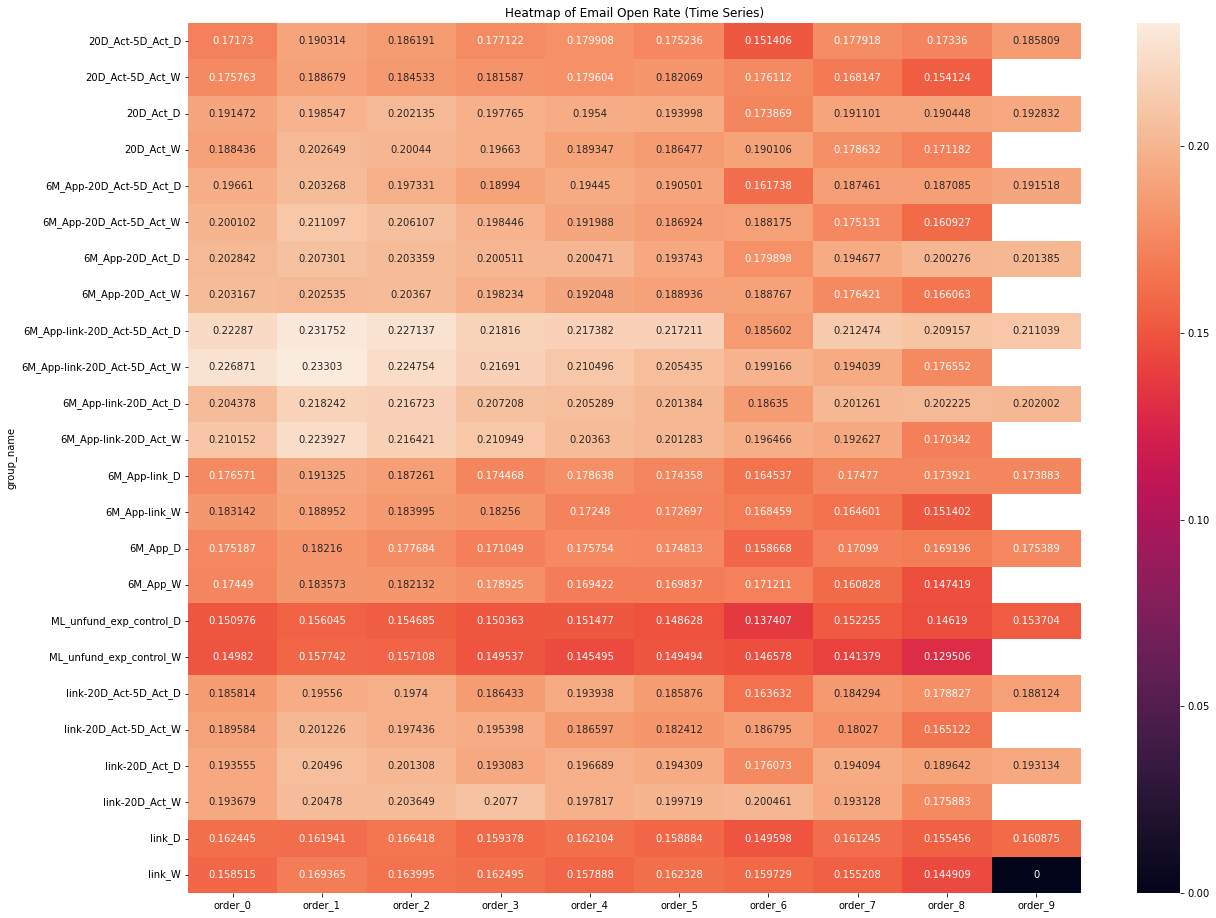

In [36]:
#visualize open rate using heatmap
heatmap = open_rate[open_rate['group_name'].str.contains('D')].set_index('group_name')
heatmap = open_rate.set_index('group_name')
fig, ax = plt.subplots(figsize = (20,16))
sns.heatmap(heatmap, annot=True, fmt='g')

plt.title("Heatmap of Email Open Rate (Time Series)")
plt.show()

As we can see from the above heatmap, day 0 does not always have highest open rate, but most groups do tend not to open emails after few days. Since in the heatmap we could see that day 2 have higher open rate, we could send 2-3 emails in the future.

#### b.	Based on our current data, do you think the experiment has completely finished? 
Based on our currect data, we can clearly see that in group of twice a week frequencies, they have not recieved their last email, so the experiment has not completely finished.